<a id="top"></a>

# Cycling Counts (Regression)

# Outline

- [Read Data](#read_data)
- [Create target and features](#create_y_and_X)
- [Split data into train and test](#train_test_split)
- [View descriptive statistics](#descriptive_statistics)
- [View target and feature distributions](#distributions)
- [View correlations](#correlations)
- [View relationships between target and features](#pair_plots)
- [Standardize predictors](#standardize_predictors)
- [Predictive models](#predictive_models)
- [Linear regression](#linear_regression)
- [K-nearest neighbors](#k_nearest_neighbors)
- [Elasticnet](#elasticnet)
- [Support vector machines](#support_vector_machines)
- [Random Forest](#random_forest)
- [Compare models](#compare_models)
- [Prophet forecast](#fbprophet)

# Import packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from time import time
from pprint import pprint

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

<a id="read_data"></a>

# [Read data](https://github.com/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb)

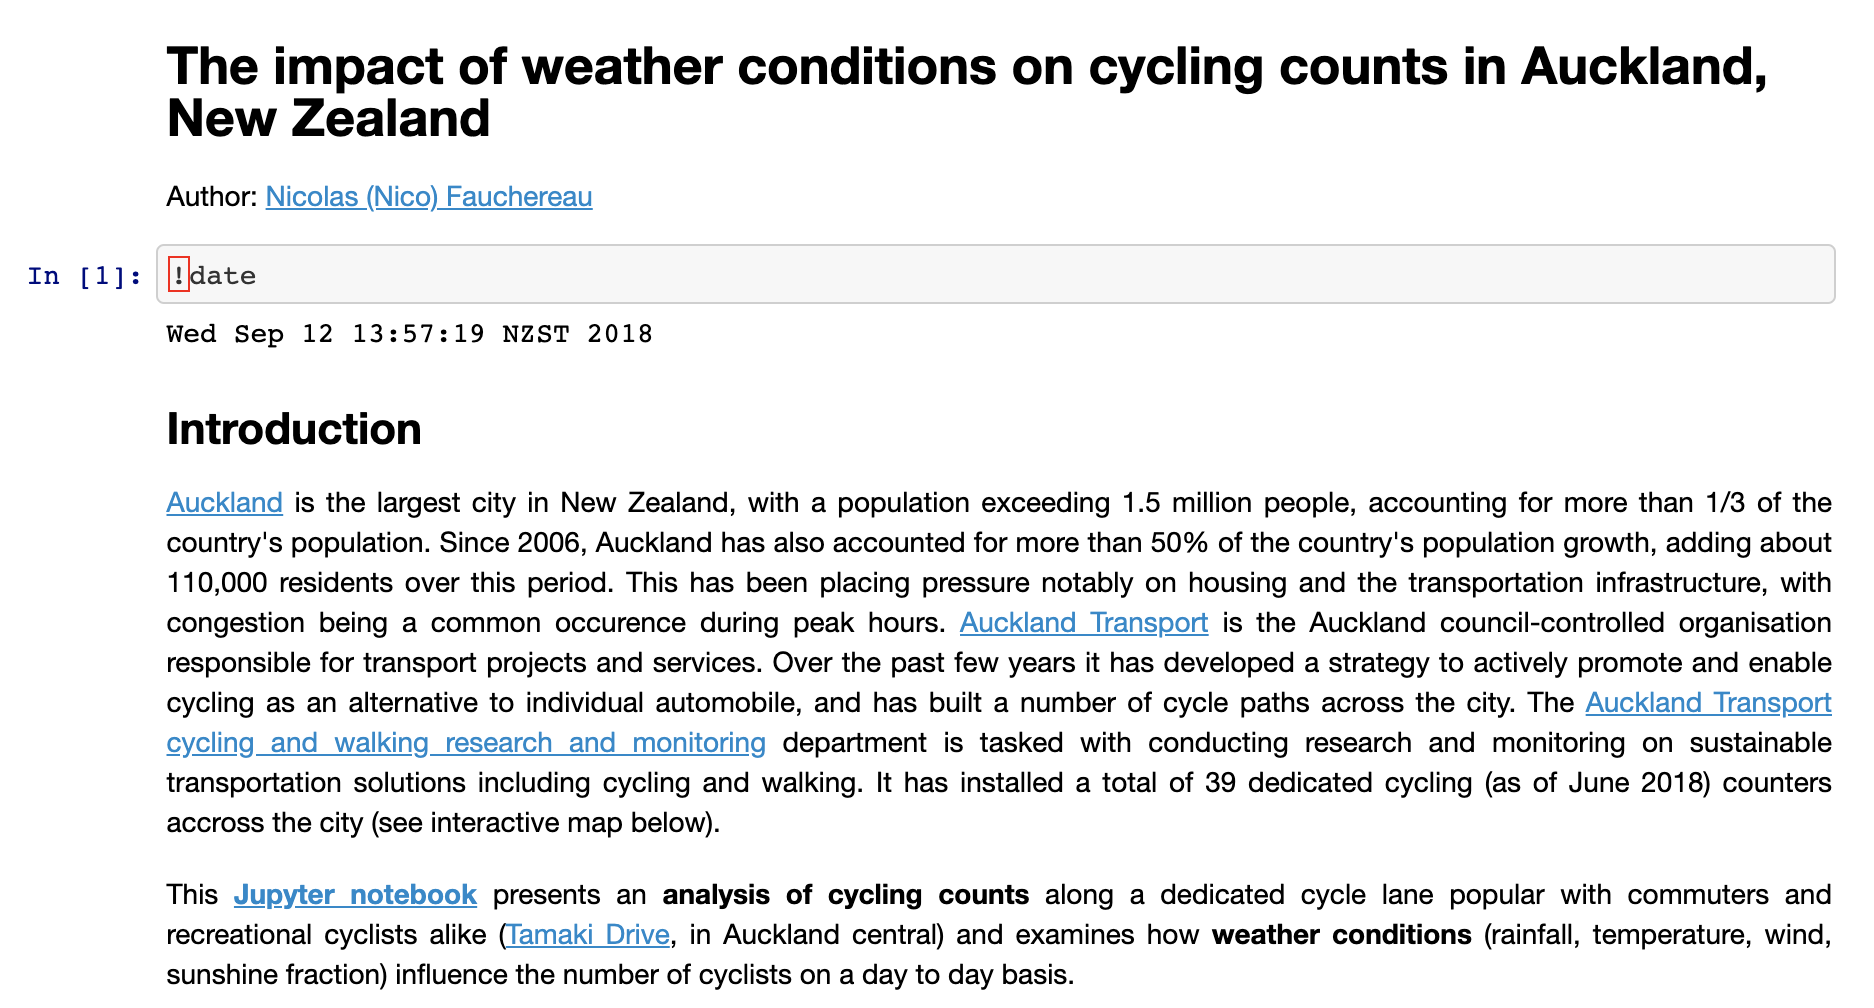

In [3]:
Image(filename='../images/cycling_counts_notebook.png', width=900)

In [ ]:
from google.colab import files
files.upload()

In [2]:
infile = '../data/auckland_cycling_weather_and_holidays.csv'

In [3]:
# remove columns to eliminate perfect colinearity:
# 'Monday', 'January', '2013',

keep_columns = ['datetime', 'y', 'temp', 'rain', 'sun', 'wind', 'Anzac Day', 'Auckland Anniversary Day', 
                'Boxing Day', 'Christmas Day', "Day after New Year's Day", 'Easter Monday', 'Good Friday', 
                'Labour Day', "New Year's Day", "Queen's Birthday", 'Waitangi Day', 'is_weekend', 
                'Friday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 
                'April', 'August', 'December', 'February', 'July', 
                'June', 'March', 'May', 'November', 'October', 'September', 
                '2014', '2015', '2016', '2017', '2018']

# Use when reading local CSV file
df = pd.read_csv(infile, usecols=keep_columns)

# Use after uploading CSV file to Google Colab
df = pd.read_csv('/content/auckland_cycling_weather_and_holidays.csv', usecols=keep_columns)

df = df.set_index(pd.DatetimeIndex(df['datetime']))
df.drop(['datetime'], axis=1, inplace=True)

df = df.astype('float32')

['{}: {}'.format(i, name) for (i, name) in enumerate(list(df.columns))]

['0: y',
 '1: temp',
 '2: rain',
 '3: sun',
 '4: wind',
 '5: Anzac Day',
 '6: Auckland Anniversary Day',
 '7: Boxing Day',
 '8: Christmas Day',
 "9: Day after New Year's Day",
 '10: Easter Monday',
 '11: Good Friday',
 '12: Labour Day',
 "13: New Year's Day",
 "14: Queen's Birthday",
 '15: Waitangi Day',
 '16: is_weekend',
 '17: Friday',
 '18: Saturday',
 '19: Sunday',
 '20: Thursday',
 '21: Tuesday',
 '22: Wednesday',
 '23: April',
 '24: August',
 '25: December',
 '26: February',
 '27: July',
 '28: June',
 '29: March',
 '30: May',
 '31: November',
 '32: October',
 '33: September',
 '34: 2014',
 '35: 2015',
 '36: 2016',
 '37: 2017',
 '38: 2018']

In [4]:
df.head().round()

,y,temp,rain,sun,wind,Anzac Day,Auckland Anniversary Day,Boxing Day,Christmas Day,Day after New Year's Day,...,March,May,November,October,September,2014,2015,2016,2017,2018
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1163.0,20.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1112.0,20.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,527.0,16.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1045.0,18.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1422.0,20.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="create_y_and_X"></a>

In [63]:
df.tail().round()

,y,temp,rain,sun,wind,Anzac Day,Auckland Anniversary Day,Boxing Day,Christmas Day,Day after New Year's Day,...,March,May,November,October,September,2014,2015,2016,2017,2018
datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-28,1107.0,9.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-05-29,1464.0,8.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-05-30,1298.0,8.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-05-31,1239.0,8.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-06-01,1196.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
df.resample('AS').count()['y']

datetime
2013-01-01    365
2014-01-01    365
2015-01-01    365
2016-01-01    366
2017-01-01    365
2018-01-01    152
Freq: AS-JAN, Name: y, dtype: int64

<a id="train_test_split"></a>

# Split data into train and test sets

In [6]:
def split_data(data, year=2017): 
    data_train = data.loc[:str(year-1), :]
    data_test  = data.loc[str(year):, :]
    #data_train.reset_index(inplace=True)
    #data_test.reset_index( inplace=True)
    #data_train = data_train.rename({'datetime':'ds'}, axis=1)
    #data_test  = data_test.rename( {'datetime':'ds'}, axis=1)
    return data_train, data_test

In [7]:
data_train, data_test = split_data(df, 2017)

In [8]:
data_train.shape, data_test.shape

((1461, 39), (517, 39))

In [9]:
data_train.head().round()

,y,temp,rain,sun,wind,Anzac Day,Auckland Anniversary Day,Boxing Day,Christmas Day,Day after New Year's Day,...,March,May,November,October,September,2014,2015,2016,2017,2018
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1163.0,20.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1112.0,20.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,527.0,16.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1045.0,18.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1422.0,20.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="descriptive_statistics"></a>

# View descriptive statistics

In [303]:
data_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
y,1461.0,1093.09,336.93,165.00,854.00,1111.00,1336.00,2262.00
temp,1461.0,16.19,3.74,6.44,13.29,16.12,19.35,24.38
rain,1461.0,0.12,0.37,0.00,0.00,0.00,0.05,4.15
sun,1461.0,0.42,0.27,0.00,0.21,0.41,0.64,0.98
wind,1461.0,5.03,2.45,0.96,3.17,4.59,6.49,14.04
Anzac Day,1461.0,0.00,0.06,0.00,0.00,0.00,0.00,1.00
Auckland Anniversary Day,1461.0,0.00,0.05,0.00,0.00,0.00,0.00,1.00
Boxing Day,1461.0,0.00,0.06,0.00,0.00,0.00,0.00,1.00
Christmas Day,1461.0,0.00,0.06,0.00,0.00,0.00,0.00,1.00
Day after New Year's Day,1461.0,0.00,0.06,0.00,0.00,0.00,0.00,1.00


# Create target, y, and predictor, X, variables

In [10]:
X_train = data_train.iloc[:, 1:].values
y_train = data_train.y.values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.y.values

print('''y_train shape: {}  X_train shape: {}
 y_test shape: {}    X_test shape: {}'''.format(y_train.shape, X_train.shape, 
                                           y_test.shape, X_test.shape))

y_train shape: (1461,)  X_train shape: (1461, 38)
 y_test shape: (517,)    X_test shape: (517, 38)


<a id="distributions"></a>

# View target distribution

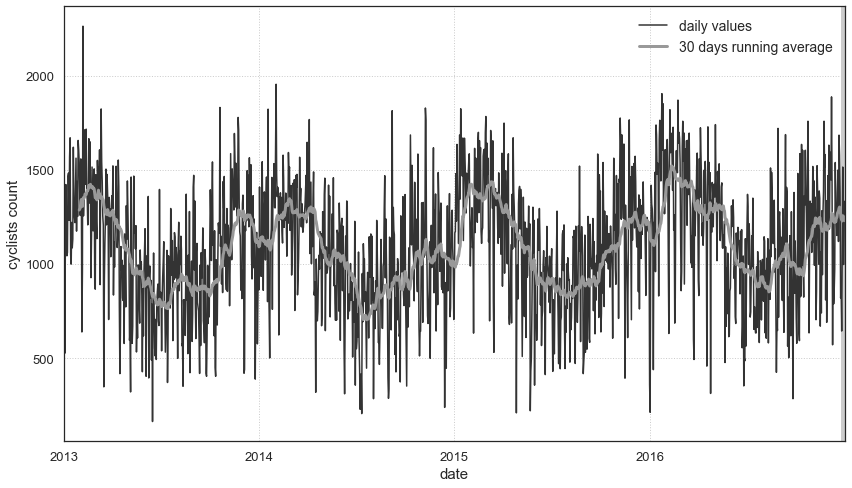

In [11]:
f, ax = plt.subplots(figsize=(14,8))

data_train.plot(y='y', ax=ax, color='0.2')

data_train['y'].rolling(window=30).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('cyclists count', fontsize=15);

ax.axvline('2017', color='0.8', lw=8, zorder=-1);

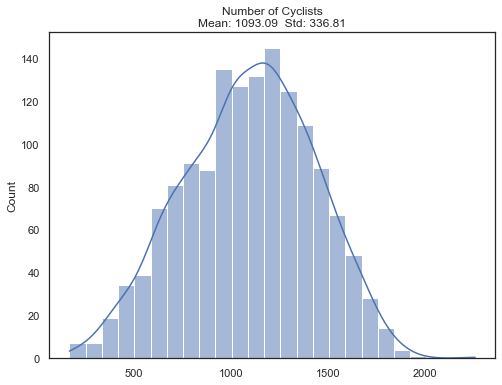

In [12]:
_, ax = plt.subplots(figsize=(8,6))
sns.histplot(y_train, kde=True, ax=ax)
ax.set_title('Number of Cyclists\nMean: {:.2f}  Std: {:.2f}'.format(y_train.mean(), y_train.std() ));

# View predictor distributions

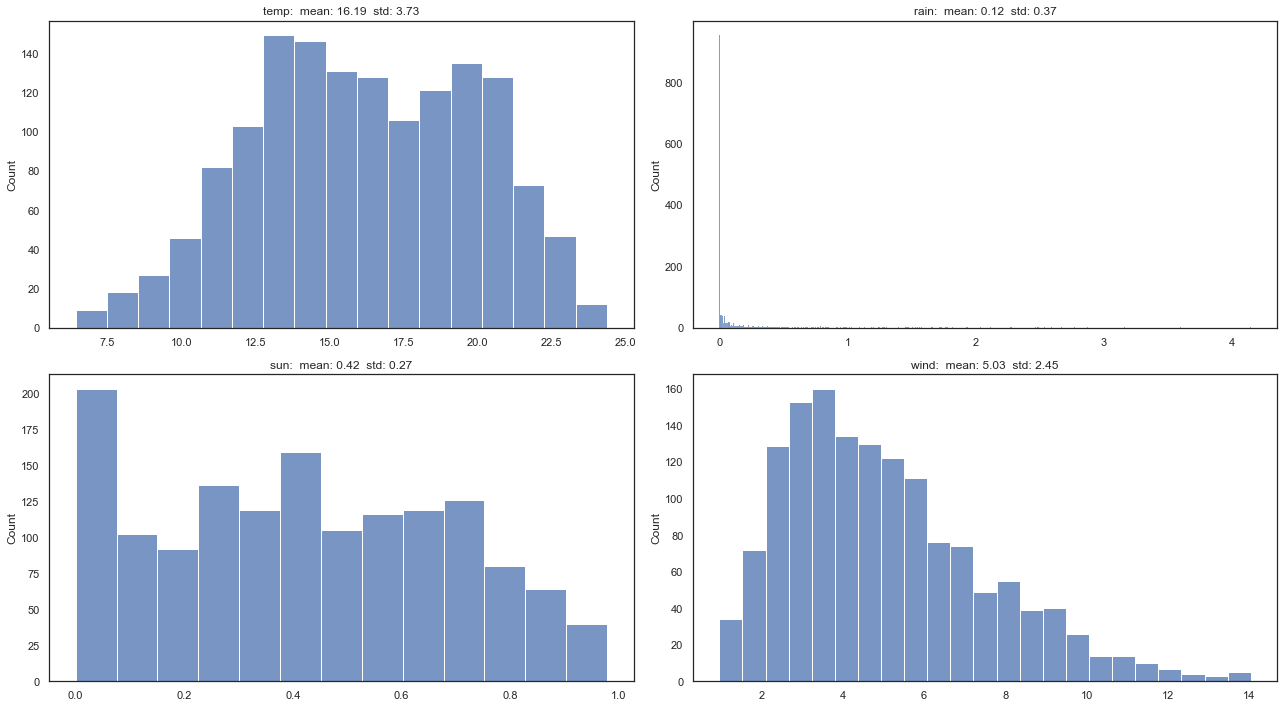

In [13]:
f, axs = plt.subplots(2, 2, figsize=(18,10))

for i, feat in enumerate(X_train.T):
    if i < 4:
        sns.histplot(feat, ax=axs.flat[i], kde=False)
        axs.flat[i].set_title('{}:  mean: {:.2f}  std: {:.2f}'.format(list(data_train.columns)[i+1], feat.mean(), feat.std()))
    else:
        pass
plt.tight_layout();

<a id="correlations"></a>

# View predictor correlations

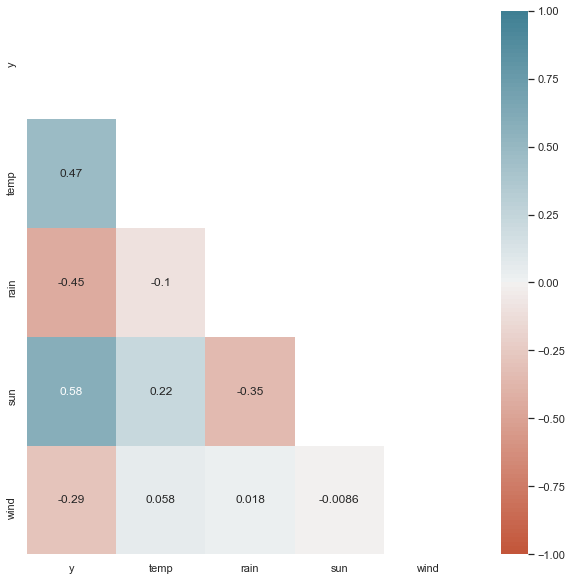

In [14]:
plt.figure(figsize=(10, 10))

matrix = np.triu(data_train.iloc[:, :5].corr())
sns.heatmap(data_train.iloc[:, :5].corr(), 
            annot=True, fmt='.2g', 
            mask=matrix, 
            vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=128));

<a id="pair_plots"></a>

# Visualize distributions of, and relationships between, target and predictors

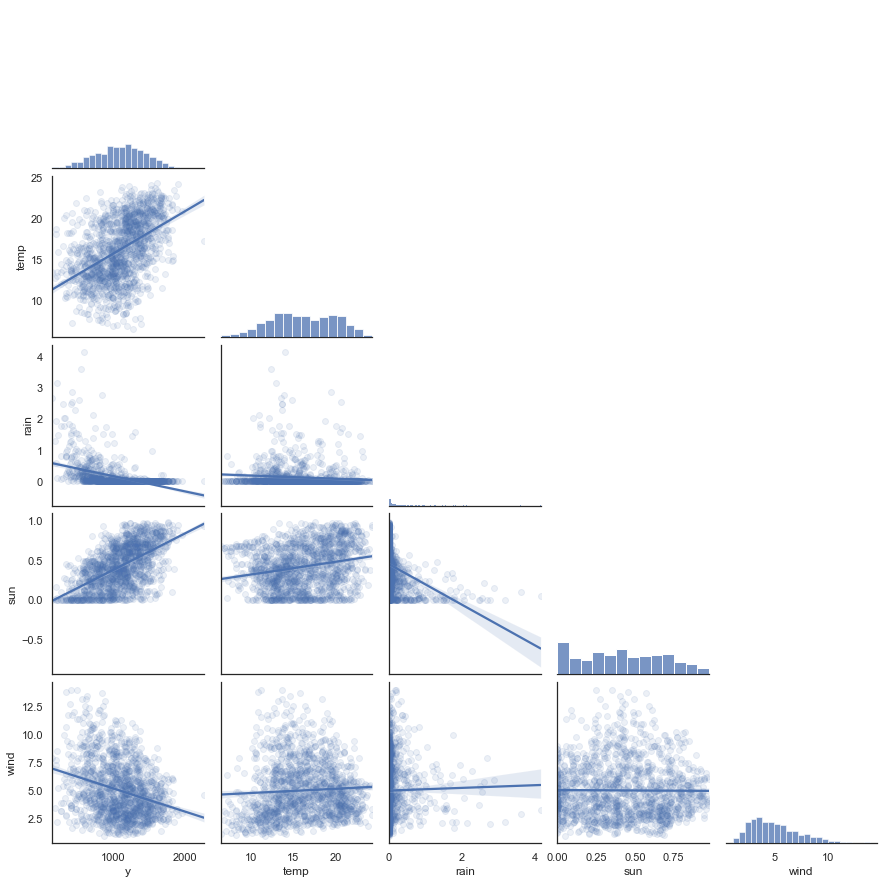

In [15]:
sns.pairplot(data_train.iloc[:, :5], 
             vars=list(data_train.columns)[:5], 
             kind='reg',
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.1}});

<a id="standardize_predictors"></a>

# Standardize the non-binary Predictors

In [16]:
binary_cols     = list(range(5, 39))
non_binary_cols = list(range(1, 5))

X_train_binary = data_train.iloc[:, binary_cols]
X_test_binary  =  data_test.iloc[:, binary_cols]

X_train_non_binary = data_train.iloc[:, non_binary_cols]
X_test_non_binary  =  data_test.iloc[:, non_binary_cols]

print('''X_train_binary shape: {}
X_test_binary shape: {}
X_train_non_binary shape: {}
X_test_non_binary shape: {}'''.format(X_train_binary.shape, 
                                      X_test_binary.shape, 
                                      X_train_non_binary.shape,
                                      X_test_non_binary.shape))

X_train_binary shape: (1461, 34)
X_test_binary shape: (517, 34)
X_train_non_binary shape: (1461, 4)
X_test_non_binary shape: (517, 4)


In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train_non_binary)  # sc.fit(X_train)

X_train_t = sc.transform(X_train_non_binary) # X_train_std = sc.transform(X_train)
X_test_t  = sc.transform( X_test_non_binary) # X_test_std  = sc.transform( X_test)

# Order matters for the plots in the next section,
# X_train_t to the left of X_train_binary in np.hstack
X_train_std = np.hstack((X_train_t, X_train_binary)) 
X_test_std  = np.hstack((X_test_t,  X_test_binary))  

print('''X_train_std shape: {}
X_test_std shape: {}'''.format(X_train_std.shape, X_test_std.shape))

X_train_std shape: (1461, 38)
X_test_std shape: (517, 38)


# View standardized predictor distributions

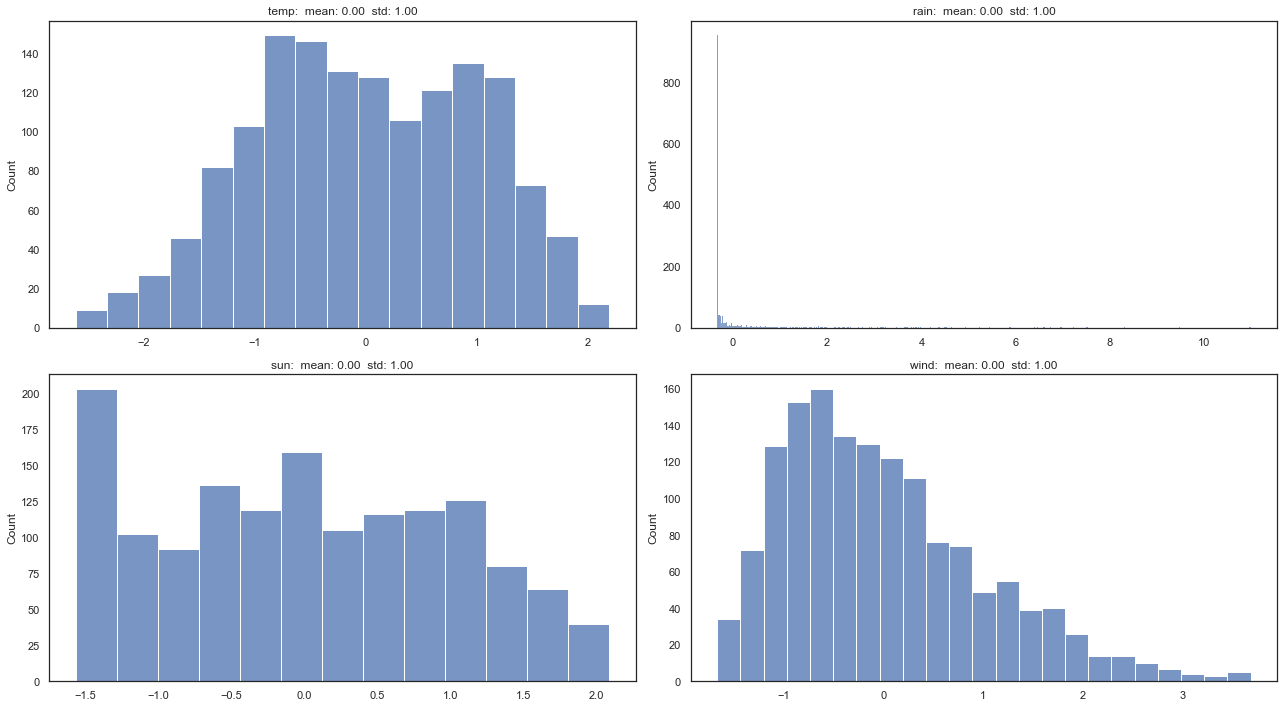

In [18]:
f, axs = plt.subplots(2, 2, figsize=(18,10))

for i, feat in enumerate(X_train_std.T):
    if i < 4:
        sns.histplot(feat, ax=axs.flat[i], kde=False)
        axs.flat[i].set_title('{}:  mean: {:.2f}  std: {:.2f}'.format(list(data_train.columns)[i+1], abs(feat.mean()), feat.std()))
    else:
        pass
plt.tight_layout();

<a id="predictive_models"></a>

# Predictive Models

# DummyRegressor estimator

In [320]:
from sklearn.dummy import DummyRegressor

d_clf = DummyRegressor(strategy='mean')
d_clf.fit(X_train_std, y_train)

print('R^2 (train): {:.2f}'.format(abs(d_clf.score(X_train_std, y_train)))) # coefficient of determination R^2
print('R^2  (test): {:.2f}'.format(abs(d_clf.score(X_test_std,  y_test))))

R^2 (train): 0.00
R^2  (test): 0.21


<a id="linear_regression"></a>

# Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

start = time()
lr.fit(X_train_std, y_train)
lr_duration = time() - start

print("LinearRegression took {:.3f} seconds.".format(lr_duration))

print('R^2 (train): {:.2f}'.format(lr.score(X_train_std, y_train)))
print('R^2  (test): {:.2f}'.format(lr.score(X_test_std,  y_test)))

LinearRegression took 0.004 seconds.
R^2 (train): 0.71
R^2  (test): 0.43


# Model parameters

In [51]:
lr_params = dict(zip(list(data_train.columns)[1:], list(lr.coef_)), 
                 intercept=lr.intercept_)
{param: value.round(2) for (param, value) in sorted(lr_params.items(), key=lambda item: item[1], reverse=True)}

{'is_weekend': 1681894.4,
 'intercept': 1049.14,
 'Labour Day': 279.93,
 'Tuesday': 193.71,
 'Auckland Anniversary Day': 161.38,
 'Wednesday': 132.1,
 'sun': 129.74,
 'Waitangi Day': 124.27,
 'Good Friday': 119.37,
 '2016': 117.69,
 'Thursday': 96.22,
 "Queen's Birthday": 90.29,
 'Easter Monday': 67.7,
 '2015': 65.5,
 'temp': 59.25,
 'Anzac Day': 47.96,
 'February': 31.61,
 'November': 5.38,
 '2017': 0.0,
 '2018': 0.0,
 'Friday': -5.12,
 '2014': -17.51,
 'March': -41.92,
 'October': -52.87,
 'December': -73.69,
 'rain': -91.83,
 'April': -102.57,
 'wind': -111.99,
 'May': -129.02,
 'September': -135.8,
 'Christmas Day': -181.82,
 'June': -201.63,
 'August': -207.66,
 'Boxing Day': -218.25,
 "Day after New Year's Day": -220.01,
 'July': -230.06,
 "New Year's Day": -455.7,
 'Saturday': -1681751.2,
 'Sunday': -1681762.2}

# Predicted values

In [52]:
predictions = lr.predict(X_test_std)

np.round(predictions)[:30] # show the first 30 predicted values

array([ 840.,  684.,  527.,  920., 1422., 1309., 1250., 1075., 1077.,
       1087., 1205., 1369., 1044., 1490.,  985., 1181., 1390., 1175.,
        954., 1088., 1083.,  963.,  813., 1454., 1025., 1321., 1180.,
       1490., 1476., 1504.], dtype=float32)

In [53]:
def combine_train_and_forecast(forecast, data_train, data_test): 
    forecast = pd.DataFrame({'forecast': forecast})
    forecast.set_index(pd.to_datetime(data_test.index), inplace=True)
    data = pd.concat([data_train, data_test], axis=0)
    data_forecast = data.merge(forecast, how='left', left_index=True, right_index=True)
    return data_forecast

In [54]:
def plot_train_and_forecast(verif, year=2017):
    f, ax = plt.subplots(figsize=(14, 8))   
    train = verif.loc[:str(year-1),:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    train['y'].rolling(window=30).mean().plot(ax=ax, ls='-', lw=2, color='0.6')

    test = verif.loc[str(year):,:]
    ax.plot(test.index, test.y, 'bo', markersize=3)
    ax.plot(test.index, test.forecast, color='lightblue', lw=0.5)
    test['y'].rolling(window=30).mean().plot(ax=ax, ls='-', lw=2, color='0.6')

    ax.axvline(pd.to_datetime('2017-01-01'), color='0.8', alpha=0.7, zorder=-1)
    ax.grid(ls=':', lw=0.5);

In [55]:
train_and_forecast = combine_train_and_forecast(predictions, data_train, data_test)

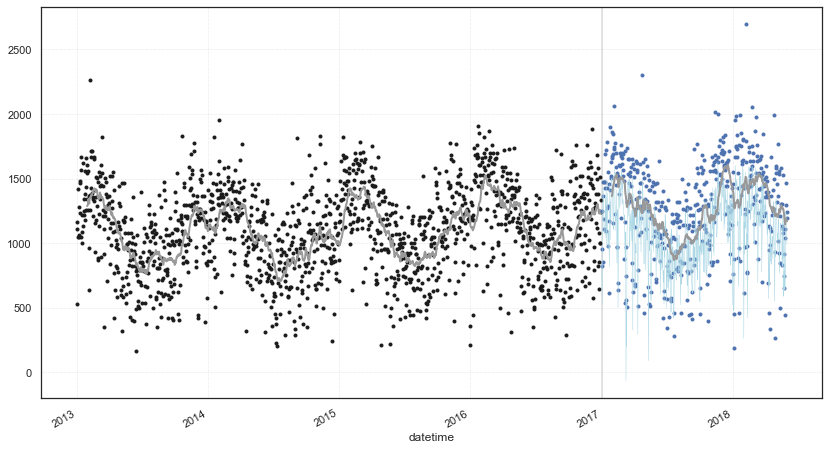

In [56]:
plot_train_and_forecast(train_and_forecast)

<a id="time_series_split"></a>

# [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

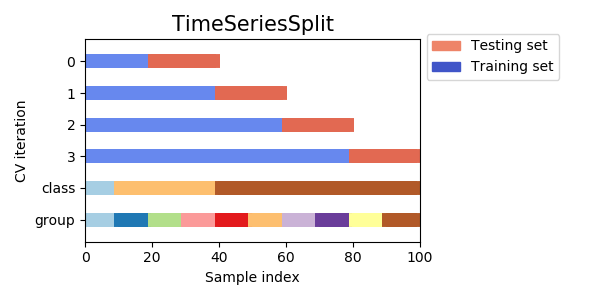

In [153]:
# Visualizing cross-validation behavior in scikit-learn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
# Data: 100 randomly generated input datapoints, 3 classes split unevenly across datapoints, 
# 10 "groups" split evenly across datapoints, 4-fold CV
Image(filename='../images/time_series_split.png', width=600)

In [76]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []
for k, (train, test) in enumerate(tscv.split(X_train_std, y_train)):
    lr.fit(X_train[train], y_train[train])
    preds = lr.predict(X_train[test])
    score = mean_squared_error(y_train[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, RMSE: {:.3f}'.format(k+1, score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, RMSE: 214.833
Fold:  2, RMSE: 171.871
Fold:  3, RMSE: 236.085
Fold:  4, RMSE: 224.282
Fold:  5, RMSE: 190.037

CV RMSE: 207.422 (+/- 52.219)


# A collection of metrics for comparing models

In [329]:
def calculate_metrics(y_true, y_pred, duration, model_name, *args):
    r2   = r2_score(y_true, y_pred)
    ev   = explained_variance_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    metrics = ['R^2', 'explained_variance', 'mse', 'rmse', 'mae', 'time_to_fit (seconds)']
    s = pd.Series([r2, ev, mse, rmse, mae, duration], index=metrics)
    s.name = model_name
    return s

In [330]:
lr_metrics = calculate_metrics(y_test, predictions, lr_duration, 'linear_regression')
lr_metrics.round(2)

R^2                          0.43
explained_variance           0.68
mse                      82954.82
rmse                       288.02
mae                        244.48
time_to_fit (seconds)        0.00
Name: linear_regression, dtype: float64

<a id="k_nearest_neighbors"></a>

# K-Nearest Neighbors

In [284]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

start = time()
knn.fit(X_train_std, y_train)
knn_duration = time() - start

print("K-Nearest Neighbors took {:.3f} seconds.".format(knn_duration))

print('R^2 (train): {:.2f}'.format(knn.score(X_train_std, y_train)))
print('R^2  (test): {:.2f}'.format(knn.score(X_test_std,  y_test)))

K-Nearest Neighbors took 0.005 seconds.
R^2 (train): 0.75
R^2  (test): 0.66


In [331]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []
for k, (train, test) in enumerate(tscv.split(X_train_std, y_train)):
    knn.fit(X_train[train], y_train[train])
    preds = knn.predict(X_train[test])
    score = mean_squared_error(y_train[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, RMSE: {:.3f}'.format(k+1, score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, RMSE: 283.745
Fold:  2, RMSE: 272.724
Fold:  3, RMSE: 226.986
Fold:  4, RMSE: 299.400
Fold:  5, RMSE: 277.861

CV RMSE: 272.143 (+/- 54.311)


# A collection of metrics for comparing models

In [333]:
y_pred = knn.predict(X_test_std)

knn_metrics = calculate_metrics(y_test, y_pred, knn_duration, 'k-nearest neighbors')
knn_metrics.round(2)

R^2                          -0.08
explained_variance            0.00
mse                      156440.77
rmse                        395.53
mae                         327.86
time_to_fit (seconds)         0.00
Name: k-nearest neighbors, dtype: float64

<a id="elasticnet"></a>

# ElasticNet

In [337]:
from sklearn.linear_model import ElasticNet

# l1_ratio = 0 the penalty is an L2 penalty (Ridge)
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2

enet = ElasticNet(random_state=0)

start = time()
enet.fit(X_train_std, y_train)
enet_duration = time() - start

print("ElasticNet took {:.3f} seconds.".format(enet_duration))

print('R^2 (train): {:.2f}'.format(enet.score(X_train_std, y_train)))
print('R^2  (test): {:.2f}'.format(enet.score(X_test_std,  y_test)))

ElasticNet took 0.003 seconds.
R^2 (train): 0.60
R^2  (test): 0.39


In [338]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []
for k, (train, test) in enumerate(tscv.split(X_train_std, y_train)):
    enet.fit(X_train[train], y_train[train])
    preds = enet.predict(X_train[test])
    score = mean_squared_error(y_train[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, RMSE: {:.3f}'.format(k+1, score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, RMSE: 246.502
Fold:  2, RMSE: 258.166
Fold:  3, RMSE: 236.116
Fold:  4, RMSE: 283.149
Fold:  5, RMSE: 268.971

CV RMSE: 258.581 (+/- 36.909)


# A collection of metrics for comparing models

In [339]:
y_pred = enet.predict(X_test_std)

enet_metrics = calculate_metrics(y_test, y_pred, enet_duration, 'elasticnet')
enet_metrics.round(2)

R^2                          -2.63
explained_variance            0.45
mse                      526115.88
rmse                        725.34
mae                         669.01
time_to_fit (seconds)         0.00
Name: elasticnet, dtype: float64

<a id="support_vector_machines"></a>

# Support Vector Machines

In [340]:
from sklearn.svm import LinearSVR

svr = LinearSVR(random_state=0)

start = time()
svr.fit(X_train_std, y_train)
svr_duration = time() - start

print("Support Vector Machines took {:.3f} seconds.".format(svr_duration))

print('R^2 (train): {:.2f}'.format(svr.score(X_train_std, y_train)))
print('R^2  (test): {:.2f}'.format(svr.score(X_test_std,  y_test)))

Support Vector Machines took 0.010 seconds.
R^2 (train): 0.52
R^2  (test): -0.40


In [342]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []
for k, (train, test) in enumerate(tscv.split(X_train_std, y_train)):
    svr.fit(X_train[train], y_train[train])
    preds = svr.predict(X_train[test])
    score = mean_squared_error(y_train[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, RMSE: {:.3f}'.format(k+1, score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, RMSE: 271.178
Fold:  2, RMSE: 289.590
Fold:  3, RMSE: 267.658
Fold:  4, RMSE: 284.762
Fold:  5, RMSE: 282.763

CV RMSE: 279.190 (+/- 18.685)


# A collection of metrics for comparing models

In [341]:
y_pred = svr.predict(X_test_std)

svr_metrics = calculate_metrics(y_test, y_pred, svr_duration, 'support vector machines')
svr_metrics.round(2)

R^2                          -0.40
explained_variance            0.61
mse                      203433.23
rmse                        451.04
mae                         400.41
time_to_fit (seconds)         0.01
Name: support vector machines, dtype: float64

<a id="random_forest"></a>

# Random Forest

In [344]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(oob_score=True, 
                           n_jobs=3, random_state=0)

start = time()
rf.fit(X_train_std, y_train)
rf_duration = time() - start

print("Random Forest took {:.3f} seconds.".format(svr_duration))

print('R^2 (train): {:.2f}'.format(svr.score(X_train_std, y_train)))
print('R^2  (test): {:.2f}'.format(svr.score(X_test_std,  y_test)))

Random Forest took 0.010 seconds.
R^2 (train): -7.73
R^2  (test): -8.61


In [345]:
tscv = TimeSeriesSplit(n_splits=5)

scores = []
for k, (train, test) in enumerate(tscv.split(X_train_std, y_train)):
    rf.fit(X_train[train], y_train[train])
    preds = rf.predict(X_train[test])
    score = mean_squared_error(y_train[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, RMSE: {:.3f}'.format(k+1, score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, RMSE: 199.186
Fold:  2, RMSE: 180.782
Fold:  3, RMSE: 192.578
Fold:  4, RMSE: 216.047
Fold:  5, RMSE: 191.742

CV RMSE: 196.067 (+/- 25.951)


# A collection of metrics for comparing models

In [346]:
rf_metrics = calculate_metrics(y_test, y_pred, rf_duration, 'random forest')
rf_metrics

R^2                          -0.402922
explained_variance            0.608665
mse                      203433.231774
rmse                        451.035732
mae                         400.412118
time_to_fit (seconds)         0.434402
Name: random forest, dtype: float64

## Variable importances in the random forest model

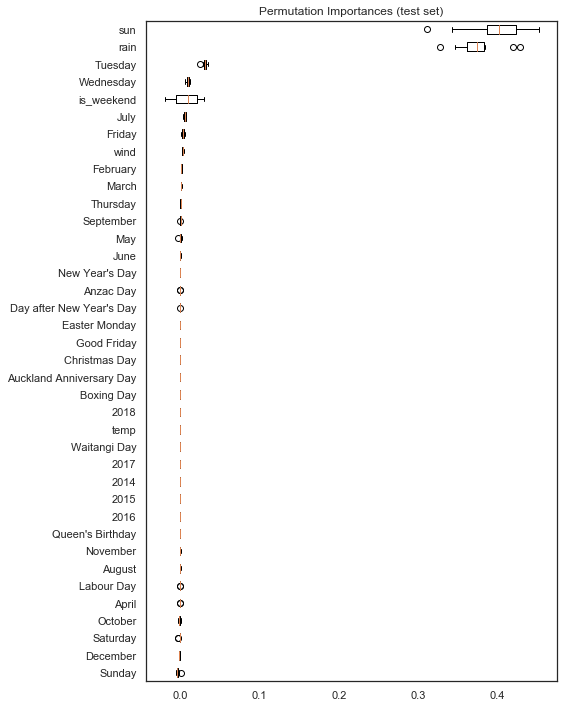

In [347]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test_std, y_test, n_repeats=10, 
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

X_test_df = pd.DataFrame(X_test_std, columns=list(data_test.columns[1:]))

f, ax = plt.subplots(figsize=(8,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_df.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.tight_layout();

<a id="compare_models"></a>

# Compare Models

# Classification metrics scores and time-to-fit models (in seconds)

In [352]:
model_metrics = pd.concat([lr_metrics, knn_metrics, enet_metrics, svr_metrics, rf_metrics], axis=1).T

model_metrics = model_metrics.apply(lambda elem: [np.round(val, 2) for val in elem]).sort_values(by='mae', ascending=True)
model_metrics

,R^2,explained_variance,mse,rmse,mae,time_to_fit (seconds)
linear_regression,0.43,0.68,82954.82,288.02,244.48,0.00
k-nearest neighbors,-0.08,0.00,156440.77,395.53,327.86,0.00
support vector machines,-0.40,0.61,203433.23,451.04,400.41,0.01
random forest,-0.40,0.61,203433.23,451.04,400.41,0.43
elasticnet,-2.63,0.45,526115.88,725.34,669.01,0.00


# Plot of mean (+/- std) cross-validation scores

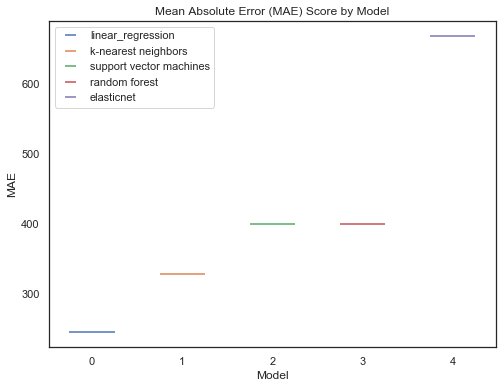

In [354]:
fig = plt.figure(figsize=(8,6))

for i in range(len(model_metrics.index)):
    plt.errorbar(x=i, y=model_metrics.iloc[i, 4], # mae column
                 xerr=0.25,
                 #yerr=model_metrics.iloc[i, 1], # standard deviation column   alternatively: [mean - p025, p975 - mean],
                 linestyle='',
                 label=list(model_metrics.index)[i])

#plt.ylim(0.5,0.8)
plt.title('Mean Absolute Error (MAE) Score by Model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.legend(loc='upper left');

<a id="fbprophet"></a>

# [Prophet](https://facebook.github.io/prophet/)

In [61]:
# Build a DataFrame of national and regional (Auckland region) holidays
import holidays  # Source: https://pypi.org/project/holidays/

holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

ldates = []
lnames = []
for date, name in sorted(holidays.NZ(prov='AUK', years=np.arange(2013, 2018 + 1)).items()):
    ldates.append(date)
    lnames.append(name)
ldates = np.array(ldates)
lnames = np.array(lnames)

holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))
holidays_df

,ds,holiday
0,2013-01-01,New Year's Day
1,2013-01-02,Day after New Year's Day
2,2013-01-28,Auckland Anniversary Day
3,2013-02-06,Waitangi Day
4,2013-03-29,Good Friday
...,...,...
67,2018-04-25,Anzac Day
68,2018-06-04,Queen's Birthday
69,2018-10-22,Labour Day
70,2018-12-25,Christmas Day


In [57]:
ds_train = data_train['y'].reset_index().rename(columns={'datetime': 'ds'})
ds_train

,ds,y
0,2013-01-01,1163.0
1,2013-01-02,1112.0
2,2013-01-03,527.0
3,2013-01-04,1045.0
4,2013-01-05,1422.0
...,...,...
1456,2016-12-27,1515.0
1457,2016-12-28,998.0
1458,2016-12-29,999.0
1459,2016-12-30,1333.0


In [58]:
ds_test = data_test['y'].reset_index().rename(columns={'datetime': 'ds'})

In [59]:
from fbprophet import Prophet

m = Prophet(mcmc_samples=300,
            holidays=holidays_df,
            holidays_prior_scale=0.25,
            changepoint_prior_scale=0.01,
            seasonality_mode='multiplicative',
            yearly_seasonality=10,
            weekly_seasonality=True,
            daily_seasonality=False)

In [60]:
m.fit(ds_train);

In [62]:
future = m.make_future_dataframe(periods=len(ds_test), freq='1D')
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1973,2018-05-28
1974,2018-05-29
1975,2018-05-30
1976,2018-05-31


In [63]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Auckland Anniversary Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,1034.327246,552.905470,1328.791856,1009.286117,1059.732998,0.0,0.0,0.0,0.0,...,0.093899,0.072210,0.114742,0.035749,-0.006911,0.077069,0.0,0.0,0.0,934.037408
1,2013-01-02,1034.369605,676.657960,1427.679357,1009.427506,1059.720358,0.0,0.0,0.0,0.0,...,0.012379,-0.006992,0.033083,0.049888,0.007332,0.091902,0.0,0.0,0.0,1052.259580
2,2013-01-03,1034.411965,721.760227,1445.339804,1009.585100,1059.707717,0.0,0.0,0.0,0.0,...,-0.005957,-0.024934,0.014045,0.065224,0.021831,0.107924,0.0,0.0,0.0,1095.718975
3,2013-01-04,1034.454324,676.943651,1395.076735,1009.764647,1059.690358,0.0,0.0,0.0,0.0,...,-0.082265,-0.104922,-0.060621,0.081560,0.038469,0.123022,0.0,0.0,0.0,1033.725360
4,2013-01-05,1034.496684,797.929453,1528.802092,1009.944194,1059.664825,0.0,0.0,0.0,0.0,...,0.038369,0.018653,0.057999,0.098677,0.056028,0.139780,0.0,0.0,0.0,1176.269350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2018-05-28,1267.636166,593.077397,1285.935931,1215.644907,1320.476657,0.0,0.0,0.0,0.0,...,-0.085129,-0.106624,-0.062085,-0.169123,-0.209230,-0.128354,0.0,0.0,0.0,945.336458
1974,2018-05-29,1267.792178,817.874005,1510.473761,1215.694186,1320.685779,0.0,0.0,0.0,0.0,...,0.093899,0.072210,0.114742,-0.173452,-0.213105,-0.134482,0.0,0.0,0.0,1166.935129
1975,2018-05-30,1267.948189,686.922261,1416.802852,1215.743465,1320.894902,0.0,0.0,0.0,0.0,...,0.012379,-0.006992,0.033083,-0.176470,-0.217086,-0.136802,0.0,0.0,0.0,1059.889661
1976,2018-05-31,1268.104201,681.364285,1378.422765,1215.792744,1321.104024,0.0,0.0,0.0,0.0,...,-0.005957,-0.024934,0.014045,-0.178228,-0.219234,-0.138681,0.0,0.0,0.0,1034.538409


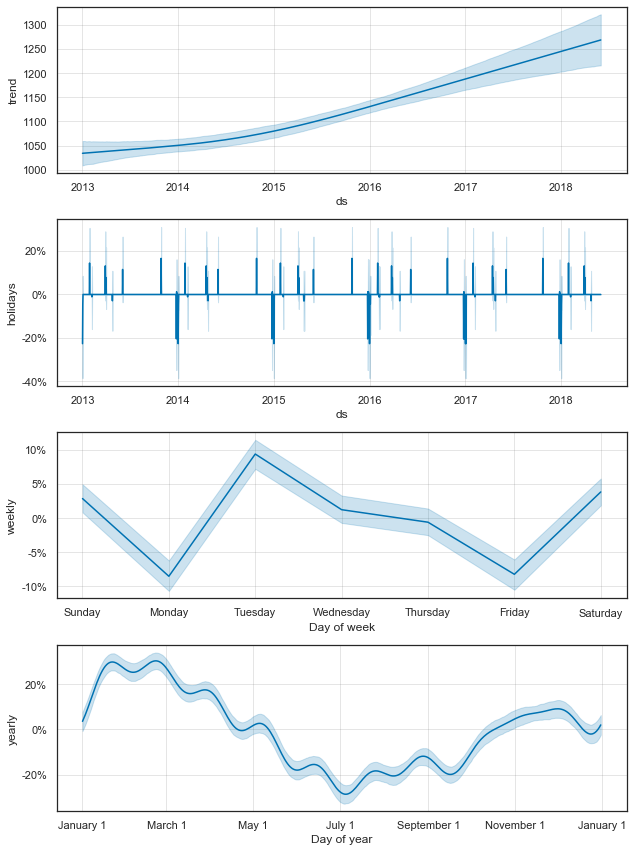

In [64]:
f = m.plot_components(forecast)

In [78]:
from sklearn.metrics import mean_absolute_error as MAE

ds_eval = train_and_forecast.merge(forecast.loc[:,['ds', 'yhat']], how='left', left_index=True, right_on='ds')

print('Mean Absolute Error (MAE): {:.2f}'.format(MAE(ds_eval.loc['2017':,'y'].values.round(), 
                                                     ds_eval.loc['2017':,'yhat'].values.round()).round(2)))

Mean Absolute Error (MAE): 230.35


[Back to top](#top)